## 导入模型

In [1]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2018)

X_train = []
X_test = []

with h5py.File("feature_resnet50.h5", 'r') as h:
    X_train.append(np.array(h['train']))
    X_test.append(np.array(h['test']))
    y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

X_train, y_train = shuffle(X_train, y_train)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 构建模型

In [2]:
from keras.models import *
from keras.layers import *

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adadelta',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


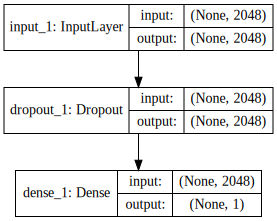

In [3]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [7]:
# model.fit(X_train, y_train, batch_size=128, nb_epoch=10, validation_split=0.2)
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath="fine_weight_resnet50.h5", monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min',
                             save_weights_only=True)

model.fit(X_train, y_train, batch_size=128, epochs=20, validation_split=0.2, shuffle=True, callbacks=[checkpoint])
model.save_weights("fine_weight_resnet50.h5")

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 1s 33us/step - loss: 0.0643 - acc: 0.9750 - val_loss: 0.0584 - val_acc: 0.9770

Epoch 00001: val_loss improved from inf to 0.05843, saving model to fine_weight_resnet50.h5
Epoch 2/20
20000/20000 [==============================] - 1s 33us/step - loss: 0.0605 - acc: 0.9770 - val_loss: 0.0598 - val_acc: 0.9762

Epoch 00002: val_loss did not improve
Epoch 3/20
20000/20000 [==============================] - 1s 33us/step - loss: 0.0607 - acc: 0.9770 - val_loss: 0.0589 - val_acc: 0.9774

Epoch 00003: val_loss did not improve
Epoch 4/20
20000/20000 [==============================] - 1s 33us/step - loss: 0.0650 - acc: 0.9752 - val_loss: 0.0585 - val_acc: 0.9772

Epoch 00004: val_loss did not improve
Epoch 5/20
20000/20000 [==============================] - 1s 33us/step - loss: 0.0643 - acc: 0.9754 - val_loss: 0.0588 - val_acc: 0.9776

Epoch 00005: val_loss did not improve
Epoch 6/20
20000/

In [8]:
# 模型预测
model.load_weights('fine_weight_resnet50.h5')
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

12500/12500 [==============================] - 0s 32us/step


In [9]:
# 模型预测
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

12500/12500 [==============================] - 0s 31us/step


In [10]:
# 测试集预测
import os
import pandas as pd
from keras.preprocessing.image import *

# 获得当前目录
current_dir = os.getcwd()
df = pd.read_csv("sample_submission.csv")

image_size = (224, 224)
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory(current_dir + "/data/test", image_size, shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('resnet50_pred.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:17: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005
